Generating Box Plots...


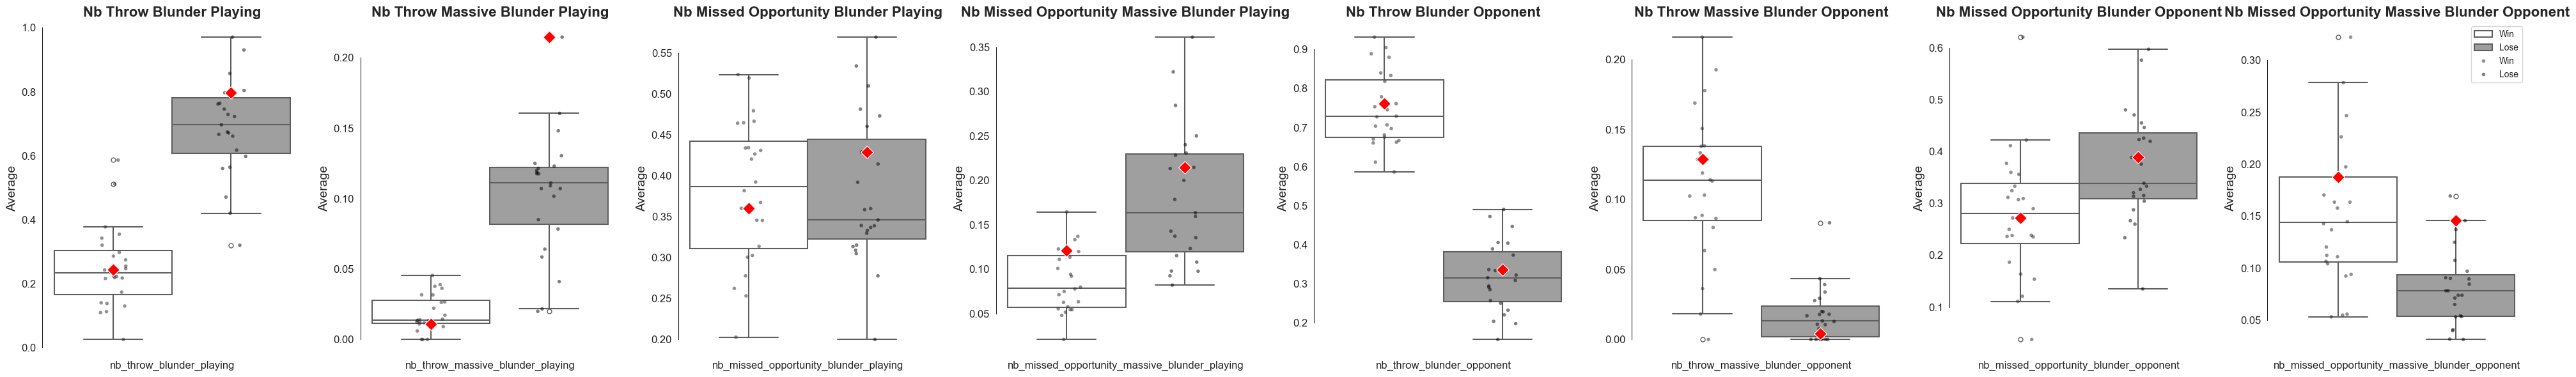


Generating Joint Plots...


C:\Users\User\AppData\Local\Temp\ipykernel_125876\3396845390.py:112: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout(rect=[0, 0, 1, 0.98])


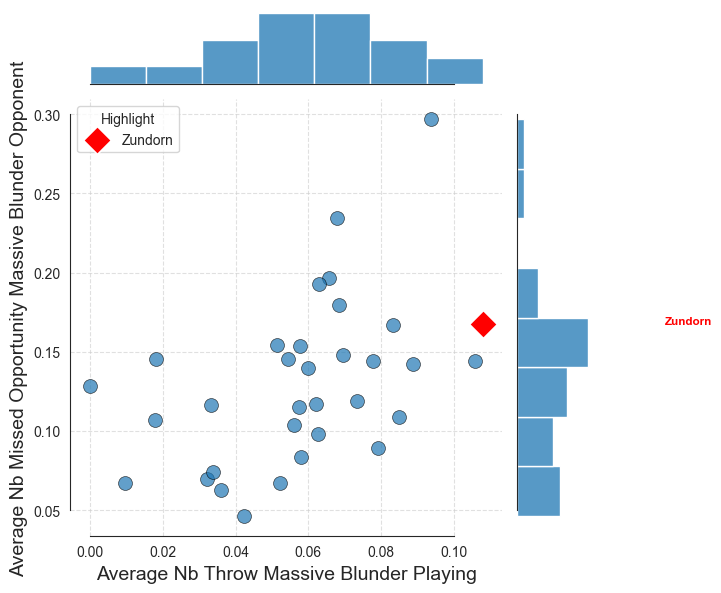

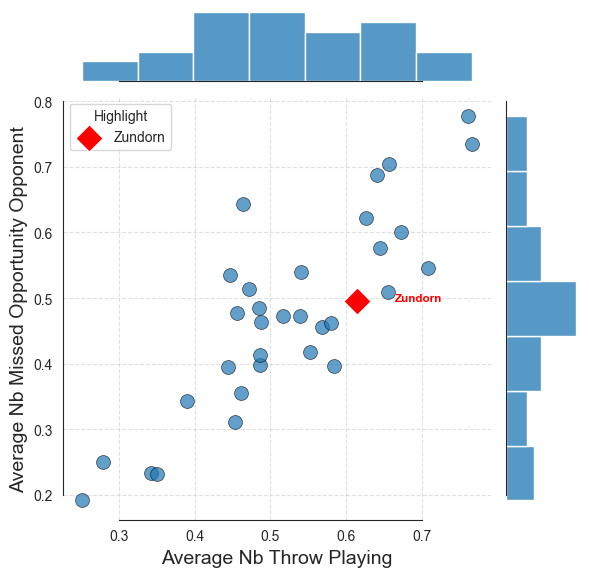

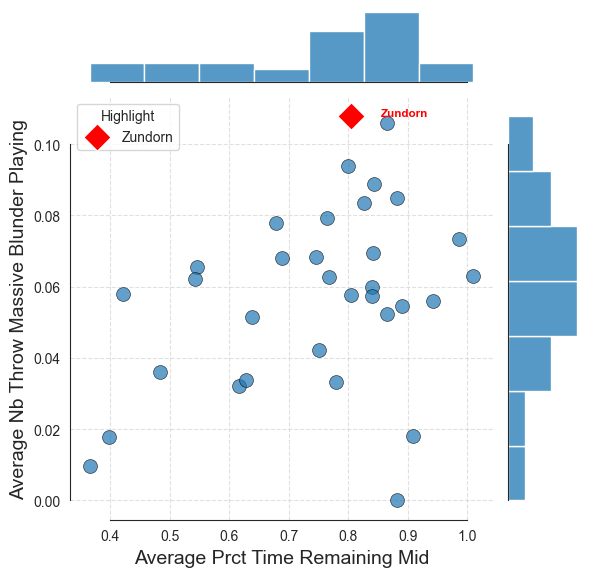

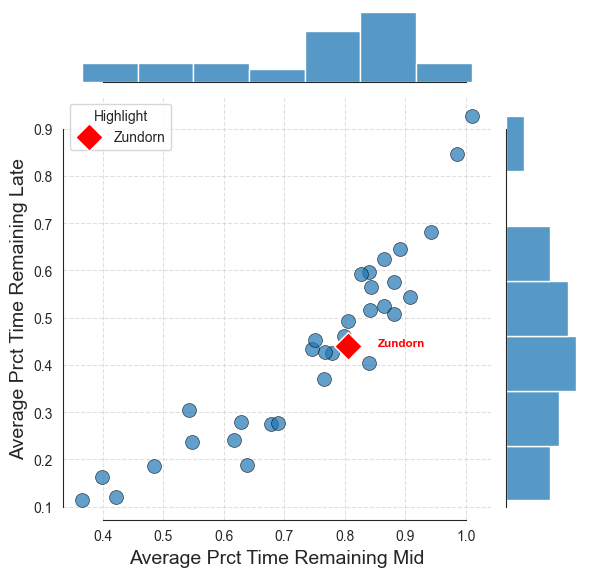

In [4]:
from data.loader import load_query
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List

def aggregate_data(df: pd.DataFrame, group_cols: list, min_games: int = 50) -> pd.DataFrame:
    """
    Filters for groups with a minimum number of games and calculates the average 
    for all numeric columns.
    """
    counts = df.groupby(group_cols).size()
    eligible_groups = counts[counts >= min_games].index
    df_filtered = df.set_index(group_cols).loc[eligible_groups].reset_index()
    # Calculate the mean for all numeric columns in the filtered DataFrame
    return df_filtered.groupby(group_cols).mean(numeric_only=True).reset_index()

def unpivot_dataset(df: pd.DataFrame, id_vars: List[str]) -> pd.DataFrame:
    """Unpivots a DataFrame from wide to long format."""
    return df.melt(id_vars=id_vars, var_name="metric", value_name="value")

def plot_box_charts_with_highlight(unpivoted_df: pd.DataFrame, user_to_highlight: str) -> None:
    """
    Generates and displays box plots for different metrics, highlighting a specific user.
    """
    sns.set_style("white")
    metrics = unpivoted_df["metric"].unique()
    highlighted_user_data = unpivoted_df[unpivoted_df["username"] == user_to_highlight]

    fig, axes = plt.subplots(1, len(metrics), figsize=(5 * len(metrics), 6), sharey=False)
    if len(metrics) == 1:
        axes = [axes]

    playing_as_order = ['Win', 'Lose']
    palette = {"Win": "#ffffff", "Lose": "#9f9f9f"}

    for i, metric in enumerate(metrics):
        ax = axes[i]
        data = unpivoted_df[unpivoted_df["metric"] == metric]

        sns.boxplot(data=data, x="metric", y="value", hue="playing_result", order=[metric],
                    hue_order=playing_as_order, palette=palette, linewidth=1.5, fliersize=5, ax=ax)

        sns.stripplot(data=data, x="metric", y="value", hue="playing_result", order=[metric],
                      hue_order=playing_as_order, dodge=True, size=4, alpha=0.5, ax=ax,
                      jitter=True, linewidth=0, edgecolor=None, palette='dark:black')

        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), title="Playing As")

        sns.despine(ax=ax, trim=True)

        user_val = highlighted_user_data[highlighted_user_data["metric"] == metric]
        if not user_val.empty:
            for _, row in user_val.iterrows():
                base_x = 0
                try:
                    hue_idx = playing_as_order.index(row["playing_result"])
                    offset = -0.2 if hue_idx == 0 else 0.2
                except ValueError:
                    offset = 0

                sns.scatterplot(x=[base_x + offset], y=[row["value"]], color="red", marker="D",
                                s=100, zorder=10, ax=ax, label=user_to_highlight if i == 0 else None)

        ax.set_title(metric.replace("_", " ").title(), fontsize=16, fontweight="bold")
        ax.set_xlabel("")
        ax.set_ylabel("Average", fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)

        if i != len(metrics) - 1:
            ax.get_legend().remove()

    plt.tight_layout()
    plt.show()

def plot_player_blunders_jointplot(df_raw: pd.DataFrame, x_col: str, y_col: str, user_to_highlight: str) -> None:
    """
    Generates a joint plot to show the relationship between two blunder metrics per player,
    highlighting a specific username.
    """
    # Aggregate data using the simplified function to get average values per player
    df_player_blunders = aggregate_data(df_raw, group_cols=['username'])

    g_player_blunders = sns.jointplot(data=df_player_blunders, x=x_col, y=y_col, kind='scatter',
                                      height=6, s=100, alpha=0.7, edgecolor="black", linewidth=0.5)

    highlighted_user_data_joint = df_player_blunders[df_player_blunders["username"] == user_to_highlight]

    if not highlighted_user_data_joint.empty:
        sns.scatterplot(x=highlighted_user_data_joint[x_col], y=highlighted_user_data_joint[y_col],
                        color="red", marker="D", s=200, zorder=10,
                        ax=g_player_blunders.ax_joint, label=user_to_highlight)
        
        g_player_blunders.ax_joint.text(highlighted_user_data_joint[x_col].iloc[0] + 0.05,
                                        highlighted_user_data_joint[y_col].iloc[0],
                                        user_to_highlight, horizontalalignment='left',
                                        size='small', color='red', weight='semibold')

    g_player_blunders.set_axis_labels(f'Average {x_col.replace("_", " ").title()}',
                                      f'Average {y_col.replace("_", " ").title()}', fontsize=14)

    g_player_blunders.ax_joint.grid(True, linestyle='--', alpha=0.6)
    sns.despine(ax=g_player_blunders.ax_joint, trim=True)
    sns.despine(ax=g_player_blunders.ax_marg_x, left=True, trim=True)
    sns.despine(ax=g_player_blunders.ax_marg_y, bottom=True, trim=True)

    if not highlighted_user_data_joint.empty:
        g_player_blunders.ax_joint.legend(title="Highlight")

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

if __name__ == "__main__":

    # --- Data Loading ---
    df_raw = load_query("data/agg_games_with_moves__games.sql")

    # --- Username ---
    user_to_highlight = "Zundorn" 

    # --- Box Plots Analysis ---
    print("Generating Box Plots...")
    # Define which metrics to display in the box plots
    box_plot_metrics = [
        "nb_throw_blunder_playing", 
        "nb_throw_massive_blunder_playing",
        "nb_missed_opportunity_blunder_playing", 
        "nb_missed_opportunity_massive_blunder_playing",

        "nb_throw_blunder_opponent", 
        "nb_throw_massive_blunder_opponent",
        "nb_missed_opportunity_blunder_opponent", 
        "nb_missed_opportunity_massive_blunder_opponent",
        # "prct_time_remaining_mid",
        # "prct_time_remaining_late",
    ]
    
    # Aggregate all numeric columns first
    df_agg_full = aggregate_data(df_raw, ["username", "playing_result"])
    df_agg_box = df_agg_full[["username", "playing_result"] + box_plot_metrics]
    
    df_unpivoted_box = unpivot_dataset(df_agg_box, id_vars=["username", "playing_result"])
    plot_box_charts_with_highlight(df_unpivoted_box, user_to_highlight)

    # --- Joint Plot Analysis ---
    # The plot_player_blunders_jointplot function now handles its own aggregation
    print("\nGenerating Joint Plots...")
    plot_player_blunders_jointplot(df_raw, "nb_throw_massive_blunder_playing", 
                                   "nb_missed_opportunity_massive_blunder_opponent", user_to_highlight)

    plot_player_blunders_jointplot(df_raw, "nb_throw_playing", 
                                   "nb_missed_opportunity_opponent", user_to_highlight)

    plot_player_blunders_jointplot(df_raw, "prct_time_remaining_mid", 
                                   "nb_throw_massive_blunder_playing", user_to_highlight)
    
    plot_player_blunders_jointplot(df_raw, "prct_time_remaining_mid", 
                                "prct_time_remaining_late", user_to_highlight)